In [1]:
# import libraries 

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Data download

In [24]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [25]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

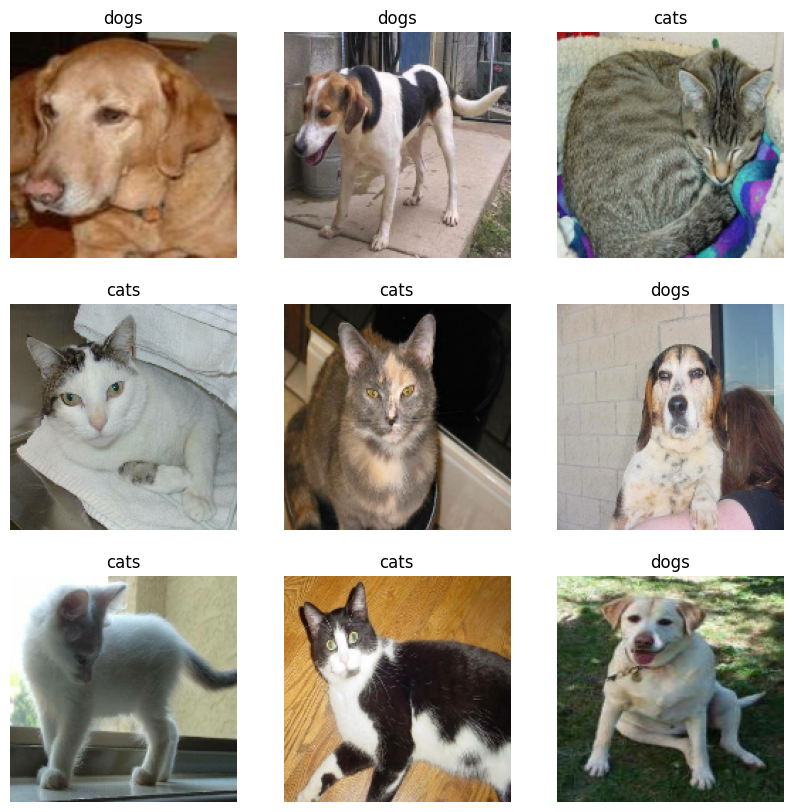

In [26]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [27]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [28]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


# Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/0 become blocking. To learn more about this method see the data peformance guide.

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

In [30]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

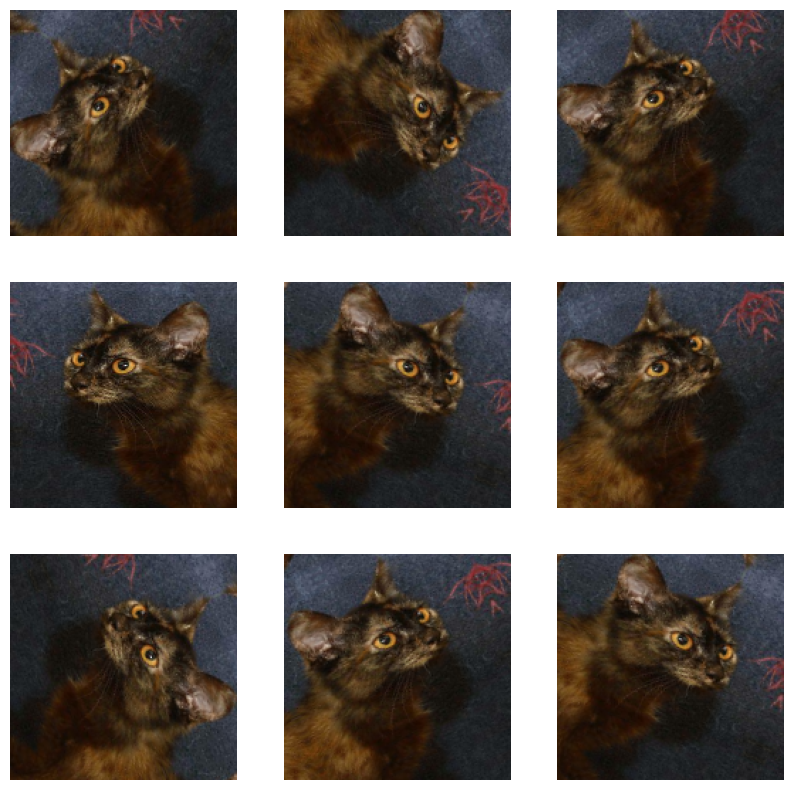

In [31]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values

In [32]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [34]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the base model from the pre-trained convnets

In [35]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights = 'imagenet')


9406464/9406464 [==============================] - 21s 2us/step


In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Freeze the convolutional base

In [37]:
base_model.trainable = False

# important note about BatchNormalization layers

In [39]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     
 ormalizat

# Add a classification head

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [41]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [42]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [44]:
len(model.trainable_variables)

2

In [45]:
# tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Compile the model

In [47]:
# for window/linux users
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]) 

# Train the model 

After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [48]:
%%time
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 21s 615ms/step - loss: 0.7154 - accuracy: 0.5903
CPU times: total: 47.5 s
Wall time: 21.3 s


In [54]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.59


In [56]:
%%time
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, verbose=0)

CPU times: total: 28min 37s
Wall time: 10min 41s


# Fine tuning

### Un-freeze the top layers of the model

In [57]:
base_model.trainable = True

In [58]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune form this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


## Compile the model

In [59]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [61]:
len(model.trainable_variables)

56

# BIG

# Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [62]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_tine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset, verbose=1)

Epoch 10/20
63/63 [==============================] - 107s 2s/step - loss: 0.1520 - accuracy: 0.9360 - val_loss: 0.0507 - val_accuracy: 0.9876
Epoch 11/20
63/63 [==============================] - 95s 2s/step - loss: 0.1248 - accuracy: 0.9475 - val_loss: 0.0379 - val_accuracy: 0.9901
Epoch 12/20
63/63 [==============================] - 99s 2s/step - loss: 0.1046 - accuracy: 0.9565 - val_loss: 0.0505 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 113s 2s/step - loss: 0.0980 - accuracy: 0.9575 - val_loss: 0.0409 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 105s 2s/step - loss: 0.0900 - accuracy: 0.9595 - val_loss: 0.0348 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 126s 2s/step - loss: 0.0872 - accuracy: 0.9620 - val_loss: 0.0279 - val_accuracy: 0.9913
Epoch 16/20
63/63 [==============================] - 106s 2s/step - loss: 0.0770 - accuracy: 0.9710 - val_loss: 0.0463 - val_accuracy: 0.9790
Epoch 17

After fine tuning the model nearly nearly reaches 98% accuracy on the validation set.

In [68]:
# Initialize the variables as lists
acc = []
val_acc = []
loss = []
val_loss = []

# Add the history data
acc += history_tine.history['accuracy']
val_acc += history_tine.history['val_accuracy']
loss += history_tune.history['loss']
val_loss += history_fine.history['val_loss']

NameError: name 'history_tune' is not defined

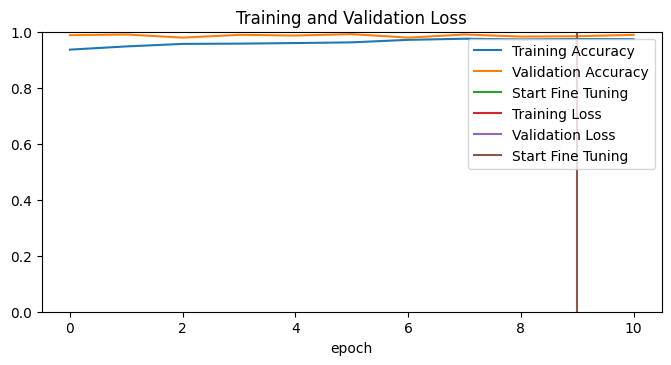

In [69]:
plt.figure(figsize=[8, 8 ])
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [71]:
# print the training and validation acccuracies of the fine-tune model
loss, accuracy = model.evaluate(train_dataset)
print("Training accuracyL {:.2f}".format(accuracy))

loss, accuracy = model.evaluate(validation_dataset)
print("validation accuracy: {:.2f}".format(accuracy))

63/63 [==============================] - 43s 659ms/step - loss: 0.0153 - accuracy: 0.9965
Training accuracyL 1.00
26/26 [==============================] - 16s 581ms/step - loss: 0.0387 - accuracy: 0.9851
validation accuracy: 0.99


# Evaluate and prediction 

Finally we can verify the performance of the model on new data using test set.

In [72]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 6s 724ms/step - loss: 0.0331 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


And now we are all set to use this model to predict if our pet is a cat or dog.

Predictions:
 [0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0]
Labels:
 [0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0]


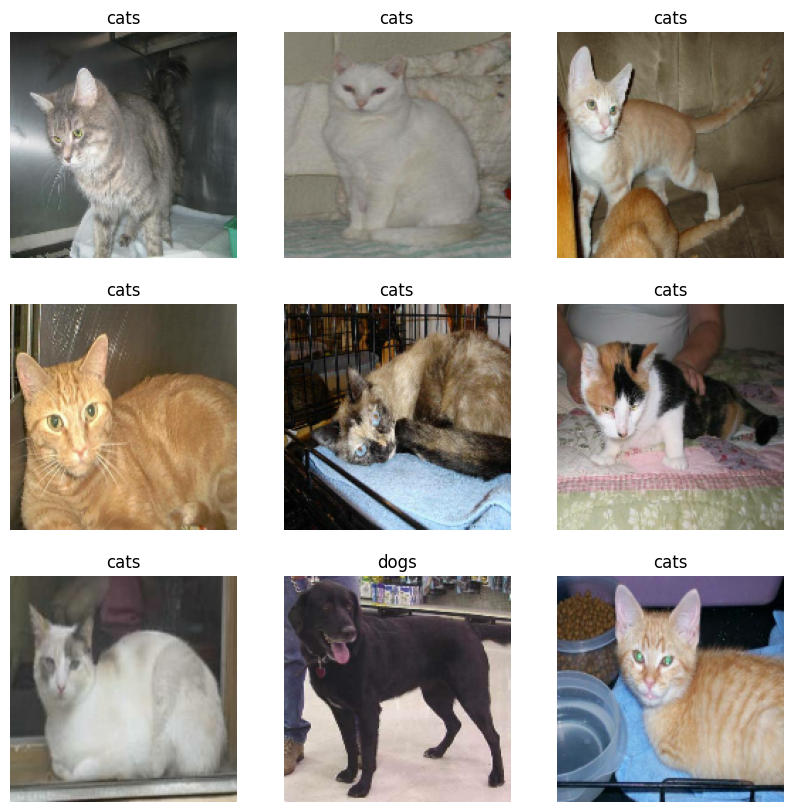

In [74]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits 
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Actually Completed